## Import libraries and user-defined functions

In [1]:
import gc
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from tabulate import tabulate
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, kendalltau

from src.loaders.data_loader import load_original_books_dataset
from src.transformers.data_transformer import transform_books_dataset


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pfaco\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pfaco\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\pfaco\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Import dataset

In [2]:
original_books_df = load_original_books_dataset()
original_books_df.sample(n=5, random_state=123)


,isbn13,authors,average_rating,publication_year,publisher,num_pages,ratings_count,text_reviews_count
6391,9780439651363,Gordon Korman,4.05,2005,Scholastic Inc.,154,4598,371
628,9780375415029,Raymond Chandler/Tom Hiney,4.45,2002,Everyman's Library,1016,241,11
10,9780739322208,Douglas Adams/Stephen Fry,4.22,2005,Random House Audio,6,1266,253
1001,9780517201664,Colleen McCullough,3.67,1999,Wings,768,39,7
6627,9780812976151,E.L. Doctorow,3.80,2006,Random House Trade Paperbacks,363,8266,831


## Data analysis - Part 1

In [3]:
original_books_df.describe()


,average_rating,publication_year,num_pages,ratings_count,text_reviews_count
count,11127.000000,11127.000000,11127.000000,1.112700e+04,11127.000000
mean,3.933631,2000.167520,336.376921,1.793641e+04,541.854498
std,0.352445,8.248836,241.127305,1.124794e+05,2576.176608
min,0.000000,1900.000000,0.000000,0.000000e+00,0.000000
25%,3.770000,1998.000000,192.000000,1.040000e+02,9.000000
50%,3.960000,2003.000000,299.000000,7.450000e+02,46.000000
75%,4.135000,2005.000000,416.000000,4.993500e+03,237.500000
max,5.000000,2020.000000,6576.000000,4.597666e+06,94265.000000


- Books with 0 values found for 'average_rating', 'num_pages' and 'ratings_count' are likely errors in the data.
- Books with 0 values found for 'average_rating' will be discarded, whereas for 'num_pages' and 'ratings_count' we will try to correct them through our book_scrapper function implemented in data_transformer.py when possible.
- 0 values for 'text_reviews_count' are possible, and won't be taken as errors in the data.
- Having old books (publication_year < 2003) up to 50% in the dataset shows that we aren't just dealing with recent literature.

## Feature engineering

This step can take some time as it involves processing some textual information of book details. Please be patient while running this part.

In [4]:
data = await transform_books_dataset(books_df=original_books_df)


Batches:   0%|          | 0/217 [00:00<?, ?it/s]

In [8]:
print(f"Covariates' number after feature engineering: {data['train']['features']['original'].shape[1]}")


Covariates' number after feature engineering: 11111


In [9]:
results = []

for data_type in data.keys():
    features = data[data_type]["features"]

    for features_version in features.keys():
        all_means = features[features_version].mean()
        all_stds = features[features_version].std()
        results.append(
            {
                "data_type": data_type,
                "features_version": features_version,
                "average_min": all_means.min(),
                "average_max": all_means.max(),
                "std_min": all_stds.min(),
                "std_max": all_stds.max(),
            }
        )

print(tabulate(pd.DataFrame(results), headers="keys", tablefmt="pretty", showindex=False, floatfmt=".2f"))


+-----------+------------------+-------------------------+------------------------+------------------------+--------------------+
| data_type | features_version |       average_min       |      average_max       |        std_min         |      std_max       |
+-----------+------------------+-------------------------+------------------------+------------------------+--------------------+
|   train   |     original     | -1.5180192295518228e-16 | 4.585149648778819e-15  |          0.0           | 1.0000643562764127 |
|   train   |      noise       | -1.0424951335476373e-16 | 1.3967605850707554e-14 |   1.0000643562764122   | 1.0000643562764127 |
|   test    |     original     |   -0.0684652037053237   |  0.04583559784073436   | 1.7349839254154006e-18 | 1.4228938599796255 |
|   test    |      noise       |  -0.042515229978691456  |  0.04583550454500346   |          0.0           | 1.4228938534828723 |
+-----------+------------------+-------------------------+------------------------+-------

- In our training dataset, there are some columns with have no variation in their values leading to a standard deviation of 0. We 'll remove all of them.
- We will also this high number of features using Principal Component Analysis (PCA).

In [10]:
del results, data_type
gc.collect()


0

## Data analysis - Part 2

 - Since all our covariates are now all numerical, we can perform a correlation analysis to understand the relationships with average_rating.
The analysis will be done only on the training dataset.
 - The noisy version of features was obtained by adding a simulated white gaussian noise to the original features values.

In [11]:
original_df = data["train"]["features"]["original"].copy(deep=True)
original_df = original_df.loc[:, ~(original_df.nunique() == 1)]

noise_df = data["train"]["features"]["noise"].copy(deep=True)
noise_df = noise_df.loc[:, ~(noise_df.nunique() == 1)]

target_df = data["train"]["targets"]


### _Features original version_

In [12]:
spearman_correlation_df = pd.DataFrame(index=original_df.columns, columns=target_df.columns)
kendall_correlation_df = pd.DataFrame(index=original_df.columns, columns=target_df.columns)

for feature in original_df.columns:
    for target in target_df.columns:
        feature_data = original_df[feature]
        target_data = target_df[target]
        spearman_correlation_df.loc[feature, target] = np.abs(spearmanr(feature_data, target_data)[0])
        kendall_correlation_df.loc[feature, target] = np.abs(kendalltau(feature_data, target_data)[0])

spearman_correlation = spearman_correlation_df.values.flatten()
kendall_correlation = kendall_correlation_df.values.flatten()

results = {
    'Correlation Type': ['Kendall', 'Spearman'],
    'Min': [np.min(kendall_correlation), np.min(spearman_correlation)],
    'Q1': [np.percentile(kendall_correlation, 25), np.percentile(spearman_correlation, 25)],
    'Median': [np.median(kendall_correlation), np.median(spearman_correlation)],
    'Q3': [np.percentile(kendall_correlation, 75), np.percentile(spearman_correlation, 75)],
    'Max': [np.max(kendall_correlation), np.max(spearman_correlation)]
}

print(tabulate(pd.DataFrame(results), headers="keys", tablefmt="pretty", showindex=False, floatfmt=".2f"))


+------------------+------------------------+----------------------+---------------------+----------------------+---------------------+
| Correlation Type |          Min           |          Q1          |       Median        |          Q3          |         Max         |
+------------------+------------------------+----------------------+---------------------+----------------------+---------------------+
|     Kendall      | 1.9396530281565064e-06 | 0.009802955784309657 | 0.02647678711197628 | 0.04237121466988905  | 0.07505297030743703 |
|     Spearman     |  8.48374663496551e-06  | 0.012569857560446141 | 0.03756963841597763 | 0.060243707075213794 | 0.10739453733566585 |
+------------------+------------------------+----------------------+---------------------+----------------------+---------------------+


None of original features is highly correlated with average_rating; even some seems to be no correlated with it.

### _Features noisy version_

In [13]:
spearman_correlation_df = pd.DataFrame(index=noise_df.columns, columns=target_df.columns)
kendall_correlation_df = pd.DataFrame(index=noise_df.columns, columns=target_df.columns)

for feature in noise_df.columns:
    for target in target_df.columns:
        feature_data = noise_df[feature]
        target_data = target_df[target]

        spearman_correlation_df.loc[feature, target] = np.abs(spearmanr(feature_data, target_data)[0])
        kendall_correlation_df.loc[feature, target] = np.abs(kendalltau(feature_data, target_data)[0])

spearman_correlation = spearman_correlation_df.astype(float).values.flatten()
kendall_correlation = kendall_correlation_df.astype(float).values.flatten()

results = {
    'Correlation Type': ['Kendall', 'Spearman'],
    'Min': [np.min(kendall_correlation), np.min(spearman_correlation)],
    'Q1': [np.percentile(kendall_correlation, 25), np.percentile(spearman_correlation, 25)],
    'Median': [np.median(kendall_correlation), np.median(spearman_correlation)],
    'Q3': [np.percentile(kendall_correlation, 75), np.percentile(spearman_correlation, 75)],
    'Max': [np.max(kendall_correlation), np.max(spearman_correlation)]
}

print(tabulate(pd.DataFrame(results), headers="keys", tablefmt="pretty", showindex=False, floatfmt=".2f"))


+------------------+------------------------+-----------------------+----------------------+----------------------+---------------------+
| Correlation Type |          Min           |          Q1           |        Median        |          Q3          |         Max         |
+------------------+------------------------+-----------------------+----------------------+----------------------+---------------------+
|     Kendall      | 6.661400497322997e-07  | 0.0037246221670706936 | 0.007984154794076425 | 0.014615412454149036 | 0.07488719793488524 |
|     Spearman     | 1.4486376338028323e-06 | 0.005540629970204562  | 0.011944069952854252 | 0.02176884384492848  | 0.10746787510807125 |
+------------------+------------------------+-----------------------+----------------------+----------------------+---------------------+


Nothing changes compared to the original features case : poor correlation with average_rating (less than 11% in absolute value).

### _Target_

In [19]:
target_column = target_df.columns[0]


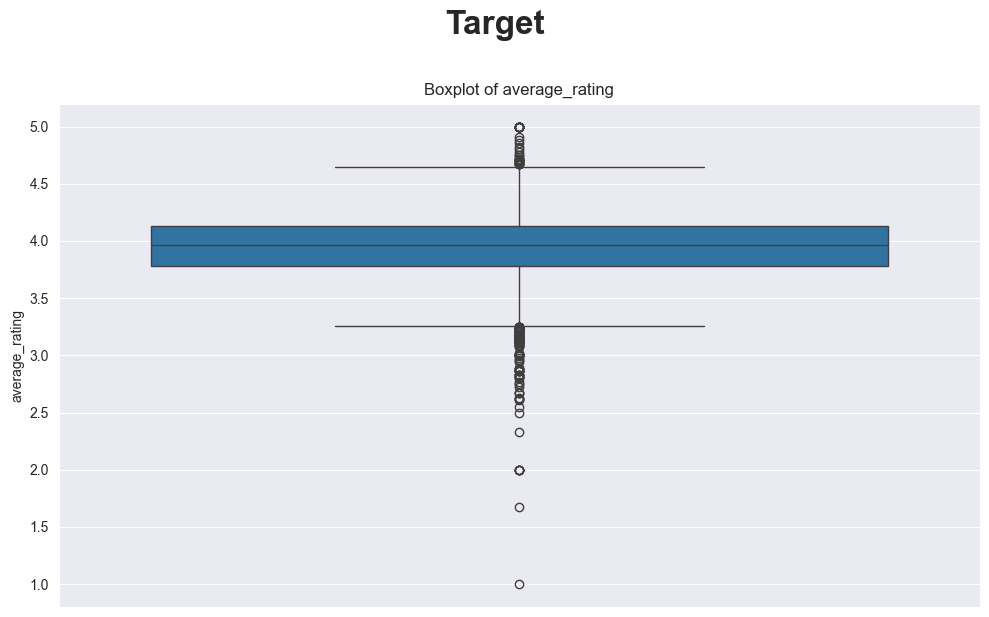

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))
fig.tight_layout(pad=3.0)

fig.suptitle(
    "Target",
    fontsize=24,
    fontweight='bold',
    y=1.02,
)

sns.boxplot(
    data=target_df,
    y=target_column,
    ax=ax,
)

ax.set_title(f"Boxplot of {target_column}")
ax.set_ylabel(target_column)
ax.set_xlabel("")

plt.tight_layout()
plt.show()


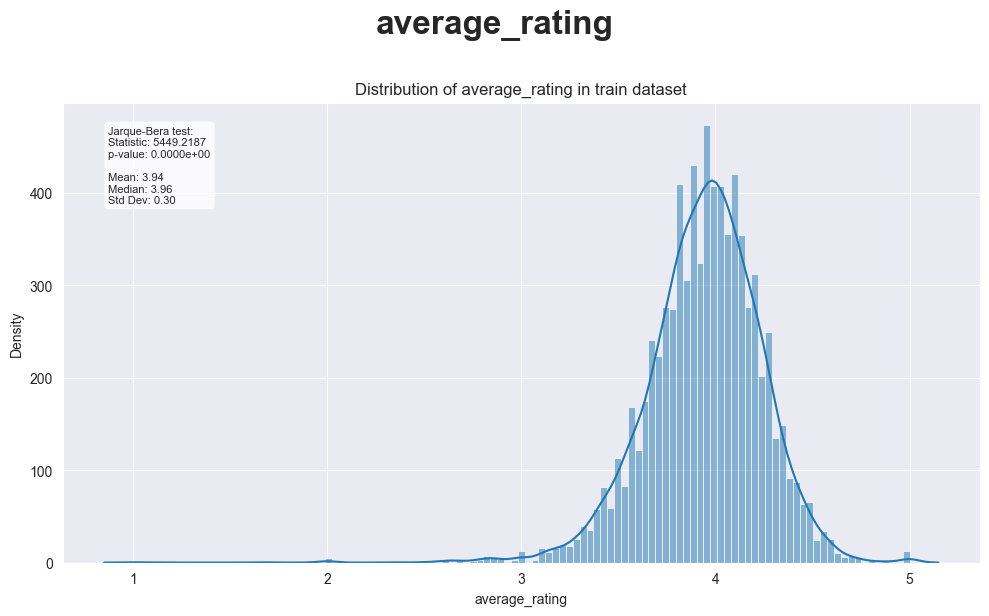

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))
fig.tight_layout(pad=3.0)

fig.suptitle(
    target_column,
    fontsize=24,
    fontweight='bold',
    y=1.02,
)

target_data = target_df[target_column]
iqr = stats.iqr(target_data)
bin_width = 2 * iqr / (len(target_data) ** (1/3))
n_bins = int((target_data.max() - target_data.min()) / bin_width)

sns.histplot(
    data=target_df,
    x=target_column,
    kde=True,
    ax=ax,
    bins=n_bins,
    kde_kws={'cut': 3}
)

statistic, p_value = stats.jarque_bera(target_data)

ax.set_title(f"Distribution of {target_column} in train dataset")
ax.set_xlabel(target_column)
ax.set_ylabel("Density")

mean = target_data.mean()
median = target_data.median()
std = target_data.std()

stats_text = (
    f"Jarque-Bera test:\n"
    f"Statistic: {statistic:.4f}\n"
    f"p-value: {p_value:.4e}\n\n"
    f"Mean: {mean:.2f}\n"
    f"Median: {median:.2f}\n"
    f"Std Dev: {std:.2f}"
)

ax.text(
    0.05, 0.95,
    stats_text,
    transform=ax.transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
    fontsize=8
)

plt.tight_layout()
plt.show()


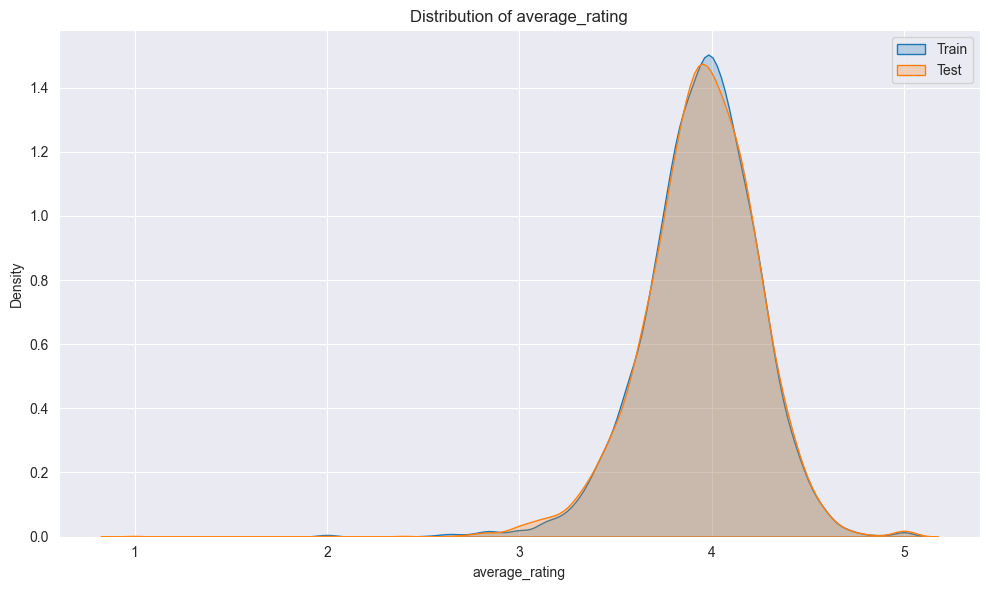

In [22]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.kdeplot(
    data=data["train"]["targets"][target_column],
    label="Train",
    fill=True,
    ax=ax,
)
sns.kdeplot(
    data=data["test"]["targets"][target_column],
    label="Test",
    fill=True,
    ax=ax,
)

ax.set_title(f"Distribution of {target_column}")
ax.set_xlabel(target_column)
ax.set_ylabel("Density")
ax.legend()

plt.tight_layout()
plt.show()


In [18]:
for target in data["train"]["targets"].columns:
    print("--------------------------------------------------")
    statistic, p_value = stats.ks_2samp(
        data1=data["train"]["targets"][target],
        data2=data["test"]["targets"][target],
    )
    print(f"Target: {target}, Kolmogorov-Smirnov statistic: {statistic:.3f}, p-value: {p_value:.3f}")
    print("--------------------------------------------------")

--------------------------------------------------
Target: average_rating, Kolmogorov-Smirnov statistic: 0.009, p-value: 0.986
--------------------------------------------------


- Using the boxplot and the histogram, we can notice that "average_rating" in the training dataset seems to have a left-skewed distribution.
- According to the Kolmogorov-Smirnov test of a 95% confidence level, the target "average_rating" has similar data distribution in the training and test sets.
- According to the Jarque-Bera test of a 95% confidence level, statistically it's not possible to say that "average_rating" is normally distributed in the training dataset.

## Launch MLflow server to record some experiments

We will run some MLflow experiments locally. Before going any further from the section `pca + elasticnet`, don't forget to start your local server with commands such as :

`mlflow server --host localhost --port 9999`.

You can change the server uri and port according to your setup.

In [ ]:
mlflow.set_tracking_uri("http://localhost:9999")

## Linear models